In [86]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
import numpy as np
from scipy.optimize import minimize

In [87]:
tickers=['VOO', 'HOOD', 'SOFI', 'QQQ', 'BULL', 'U', 'RGTI', 'BBAI']

In [88]:
end_date=datetime.today()

In [89]:
start_date=end_date-timedelta(days=5*365)
print(start_date)

2020-08-05 10:28:46.105309


In [90]:
adj_close_df=pd.DataFrame()

In [91]:
for ticker in tickers:
    data=yf.download(ticker, auto_adjust=False, start = start_date, end = end_date)
    adj_close_df[ticker] = data['Adj Close']

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [92]:
print(adj_close_df)

                   VOO        HOOD       SOFI         QQQ   BULL          U  \
Date                                                                          
2020-08-05  283.282684         NaN        NaN  263.201691    NaN        NaN   
2020-08-06  285.185760         NaN        NaN  266.687775    NaN        NaN   
2020-08-07  285.334259         NaN        NaN  263.609528    NaN        NaN   
2020-08-10  286.244080         NaN        NaN  262.483063    NaN        NaN   
2020-08-11  283.932587         NaN        NaN  257.511353    NaN        NaN   
...                ...         ...        ...         ...    ...        ...   
2025-07-28  585.440002  106.769997  21.020000  568.140015  15.72  33.490002   
2025-07-29  583.919983  103.320000  22.400000  567.260010  13.69  32.540001   
2025-07-30  583.210022  106.099998  21.870001  568.020020  13.95  32.970001   
2025-07-31  581.020020  103.050003  22.580000  565.010010  14.19  33.360001   
2025-08-01  571.450012   99.900002  21.230000  553.8

In [93]:
log_returns = np.log(adj_close_df/adj_close_df.shift(1))

In [94]:
log_returns = log_returns.dropna()

In [95]:
cov_matrix = log_returns.cov()*252
print(cov_matrix)

           VOO      HOOD      SOFI       QQQ      BULL         U      RGTI  \
VOO   0.028383  0.061142  0.060346  0.035524  0.008207  0.066056  0.073580   
HOOD  0.061142  0.393096  0.224845  0.079175  0.029199  0.217777  0.292026   
SOFI  0.060346  0.224845  0.390040  0.076110  0.003037  0.219782  0.286656   
QQQ   0.035524  0.079175  0.076110  0.048761  0.005361  0.089175  0.102583   
BULL  0.008207  0.029199  0.003037  0.005361  1.071058 -0.034332  0.032752   
U     0.066056  0.217777  0.219782  0.089175 -0.034332  0.501343  0.306391   
RGTI  0.073580  0.292026  0.286656  0.102583  0.032752  0.306391  2.138968   
BBAI  0.049438  0.252223  0.283835  0.064389 -0.002023  0.161264  0.629035   

          BBAI  
VOO   0.049438  
HOOD  0.252223  
SOFI  0.283835  
QQQ   0.064389  
BULL -0.002023  
U     0.161264  
RGTI  0.629035  
BBAI  2.150219  


In [96]:
def standard_deviation (weights, cov_matrix):
    variance= weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

In [97]:
def expected_return (weights, log_returns):
    return np.sum(log_returns.mean()*weights)*252

In [98]:
def sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return(expected_return (weights, log_returns) - risk_free_rate) / standard_deviation (weights, cov_matrix)

In [99]:
risk_free_rate = 0.0377

In [100]:
def neg_sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate):
    return -sharpe_ratio (weights, log_returns, cov_matrix, risk_free_rate)

In [101]:
constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
bounds = [(0, 0.5) for _ in range(len(tickers))]

In [102]:
initial_weights = np.array([1/len(tickers)]*len(tickers))
print(initial_weights)

[0.125 0.125 0.125 0.125 0.125 0.125 0.125 0.125]


In [103]:
optimized_results = minimize(neg_sharpe_ratio, initial_weights, args=(log_returns, cov_matrix, risk_free_rate), method='SLSQP', constraints=constraints, bounds=bounds)

In [104]:
optimal_weights = optimized_results.x

In [105]:
print("Optimal Weights:")
for ticker, weight in zip(tickers, optimal_weights):
    print(f"{ticker}: {weight: .4f}")
print()

optimal_portfolio_returns = expected_return(optimal_weights, log_returns)
optimal_porfolio_volatility = standard_deviation(optimal_weights, cov_matrix)
optimal_Sharpe_ratio = sharpe_ratio(optimal_weights, log_returns, cov_matrix, risk_free_rate)

print(f"Expected  Annual Return: {optimal_portfolio_returns:.4f}")
print(f"Expected Volatility: {optimal_porfolio_volatility:.4f}")
print(f"Sharpe Ratio: {optimal_Sharpe_ratio:.4f}")

Optimal Weights:
VOO:  0.2009
HOOD:  0.5000
SOFI:  0.0000
QQQ:  0.2878
BULL:  0.0112
U:  0.0000
RGTI:  0.0000
BBAI:  0.0000

Expected  Annual Return: 0.5000
Expected Volatility: 0.3784
Sharpe Ratio: 1.2217


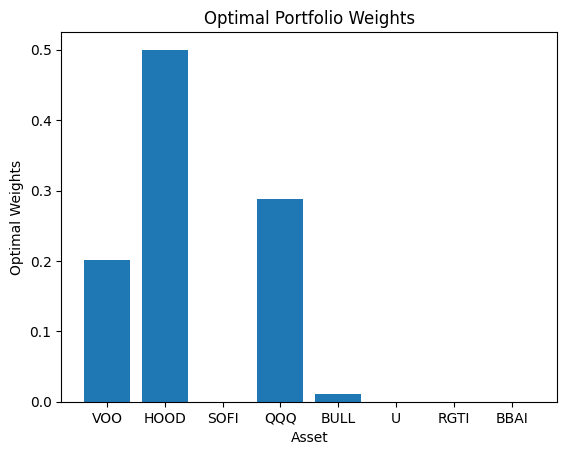

In [106]:
import matplotlib.pyplot as plot
plot.Figure(figsize=(10, 6))
plot.bar(tickers, optimal_weights)

plot.xlabel("Asset")
plot.ylabel("Optimal Weights")
plot.title("Optimal Portfolio Weights")
plot.show()